In [20]:
import pandas as pd

In [21]:
train = pd.read_csv("kaggle dataset/train.csv")
test = pd.read_csv("kaggle dataset/test.csv")

In [22]:
train.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [23]:
test.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [24]:
train.isna().sum(),test.isna().sum()

(id           0
 title      558
 author    1957
 text        39
 label        0
 dtype: int64,
 id          0
 title     122
 author    503
 text        7
 dtype: int64)

In [25]:
train.drop(['id','author'],axis=1,inplace=True)
test.drop(['id','author'],axis=1,inplace=True)

In [26]:
train.dropna(inplace=True)
test.dropna(inplace=True)

In [27]:
train.isna().sum(),test.isna().sum()

(title    0
 text     0
 label    0
 dtype: int64,
 title    0
 text     0
 dtype: int64)

In [28]:
train.shape,test.shape

((20203, 3), (5071, 2))

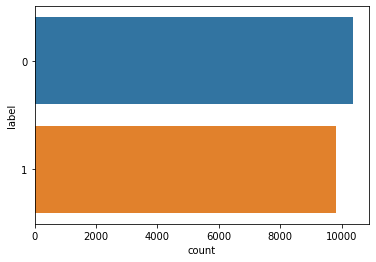

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.countplot(y = "label", data = train)
plt.show()

In [37]:
import string
import re
import nltk
from nltk import PorterStemmer, WordNetLemmatizer
ps = PorterStemmer()
word_net = WordNetLemmatizer()
stopwords = nltk.corpus.stopwords.words('english')
def text_clean(text,stem):
    text =  ("".join([s for s in text if s not in string.punctuation]))
    text = re.split('\s+' ,text)
    tokens = [x.lower() for x in text]
    tokens = [w for w in tokens if w not in stopwords]
    if stem == 0:
        #print("Stemming with Portstemmer")
        token_stem = [ps.stem(word) for word in tokens]
        sents = " ".join([word for word in token_stem])
    else:
        #print("Stemming with Lemmatize")
        token_stem_lem = [word_net.lemmatize(word) for word in tokens]
        sents = " ".join([word for word in token_stem_lem])
        
    return sents

In [38]:
train['title_text'] = train['title'].str.cat(train[['text']], sep=' - ')
test['title_text'] = test['title'].str.cat(test[['text']], sep=' - ')

In [39]:
from wordcloud import WordCloud, ImageColorGenerator
def plots(train):
    plt.figure(figsize = (15,15))
    w = WordCloud(max_words = 5000 , width = 1600 , height = 800).generate(" ".join(train[train.label == 1].clean_text))
    plt.imshow(w, interpolation = 'bilinear')
    
    plt.figure(figsize = (15,15))
    w = WordCloud(max_words = 5000 , width = 1600 , height = 800).generate(" ".join(train[train.label == 0].clean_text))
    plt.imshow(w, interpolation = 'bilinear')

def preporcess(stem,train):
    train['clean_text'] = train['title_text'].apply(lambda x : text_clean(x,stem))
    plots(train)

In [40]:
from sklearn.model_selection import train_test_split
def datasplit(data):
    dx = data['clean_text']
    dy = data['label']
    X_train, X_test, y_train, y_test = train_test_split(dx, dy, test_size = 0.2)
    print("Shape of train and test data",X_train.shape, X_test.shape)
    
    return X_train, X_test, y_train, y_test


In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
# method 0 = countvectorize and 1 for tfidfvectorizer
def datavectorize(method,xtr,xte):
    
    if method == 1:
        print("METHOD : TFIDFVECTORIZER")
        tfidf = TfidfVectorizer()
        X_train_vect = tfidf.fit_transform(xtr)
        X_test_vect = tfidf.transform(xte)
    else:
        print("METHOD : COUNTVECTORIZER")
        cvect = CountVectorizer()
        X_train_vect = cvect.fit_transform(xtr)
        X_test_vect = cvect.transform(xte)
    
    return X_train_vect,X_test_vect

def modelscore(yte,pred,name):
    print("========================================================")
    print("Model Nanme : ",name)
    print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
    print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
    print("Classification Report : \n {}".format(classification_report(y_test, pred)))
    print("========================================================")
    
def modeltrain(model,name,xtr,xte,ytr,yte):
    model.fit(xtr, ytr)
    pred = model.predict(xte)
    modelscore(yte,pred,name)

def modelling(xtr,xte,ytr,yte):
    
    log_clf = LogisticRegression(max_iter = 500)
    modeltrain(log_clf,"LogisticRegression",xtr,xte,ytr,yte)
    
    dt_clf = DecisionTreeClassifier(random_state=0)
    modeltrain(dt_clf,"DecisionTree", xtr,xte,ytr,yte)
    
    rf_clf = RandomForestClassifier(random_state=0)
    modeltrain(rf_clf,"RandomForest", xtr,xte,ytr,yte)
        
    et_clf = ExtraTreesClassifier(n_estimators=100, random_state=0)
    modeltrain(et_clf,"ExtraTree", xtr,xte,ytr,yte)
    
    svc_clf = SVC()
    modeltrain(svc_clf,"Support Vector Machine", xtr,xte,ytr,yte)
    
    mlp_clf = MLPClassifier(random_state=2, max_iter=500)  
    modeltrain(mlp_clf,"MLP", xtr,xte,ytr,yte)

Portstemmer
Shape of train and test data (16162,) (4041,)
******************************************************
METHOD : COUNTVECTORIZER
Model Nanme :  LogisticRegression
Accuracy score : 0.9599109131403119
Confusion matrix : 
 [[1938   88]
 [  74 1941]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.96      0.96      2026
           1       0.96      0.96      0.96      2015

    accuracy                           0.96      4041
   macro avg       0.96      0.96      0.96      4041
weighted avg       0.96      0.96      0.96      4041

Model Nanme :  DecisionTree
Accuracy score : 0.9532293986636972
Confusion matrix : 
 [[1937   89]
 [ 100 1915]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.95      0.96      0.95      2026
           1       0.96      0.95      0.95      2015

    accuracy                           0.95      4041
   macro avg       0.95      0.95  

Model Nanme :  RandomForest
Accuracy score : 0.9208116802771591
Confusion matrix : 
 [[1992   73]
 [ 247 1729]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.89      0.96      0.93      2065
           1       0.96      0.88      0.92      1976

    accuracy                           0.92      4041
   macro avg       0.92      0.92      0.92      4041
weighted avg       0.92      0.92      0.92      4041

Model Nanme :  ExtraTree
Accuracy score : 0.908933432318733
Confusion matrix : 
 [[2002   63]
 [ 305 1671]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.87      0.97      0.92      2065
           1       0.96      0.85      0.90      1976

    accuracy                           0.91      4041
   macro avg       0.92      0.91      0.91      4041
weighted avg       0.91      0.91      0.91      4041

Model Nanme :  Support Vector Machine
Accuracy score : 0.9552091066567682


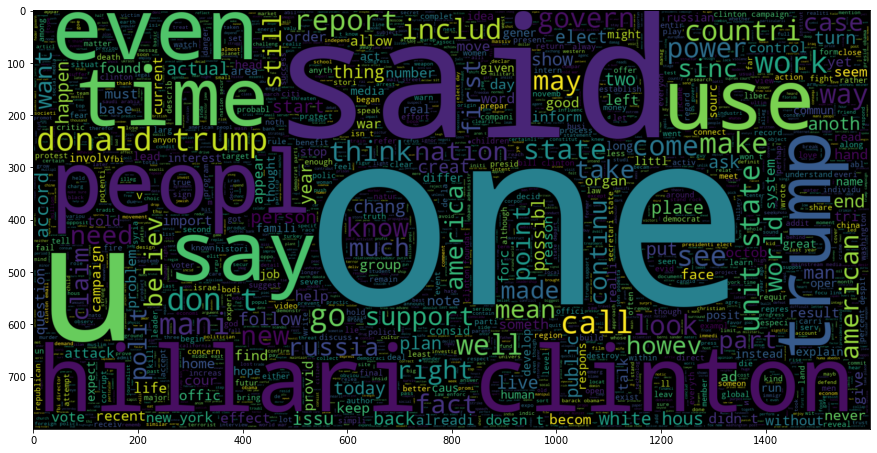

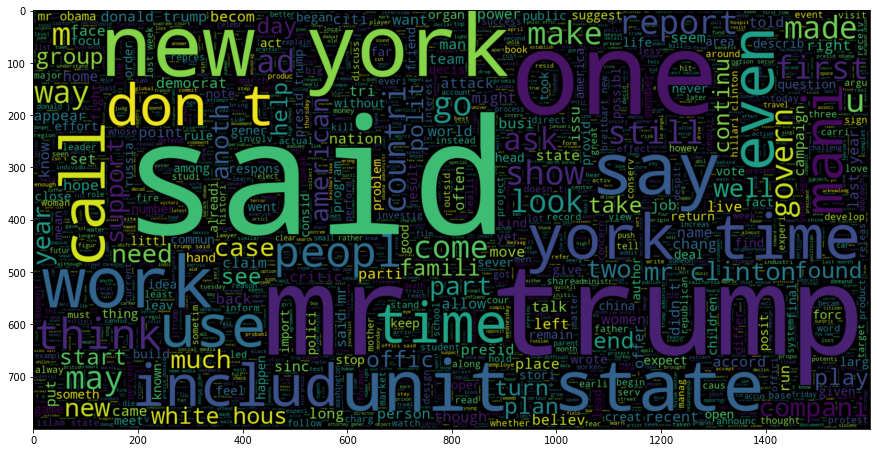

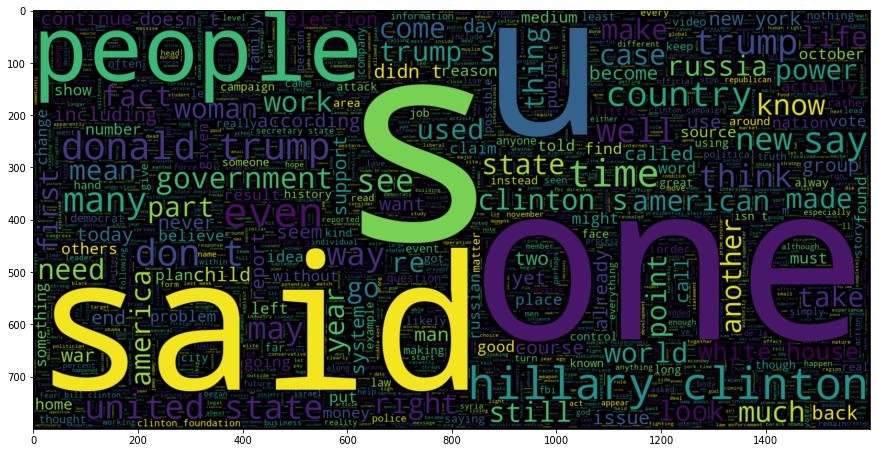

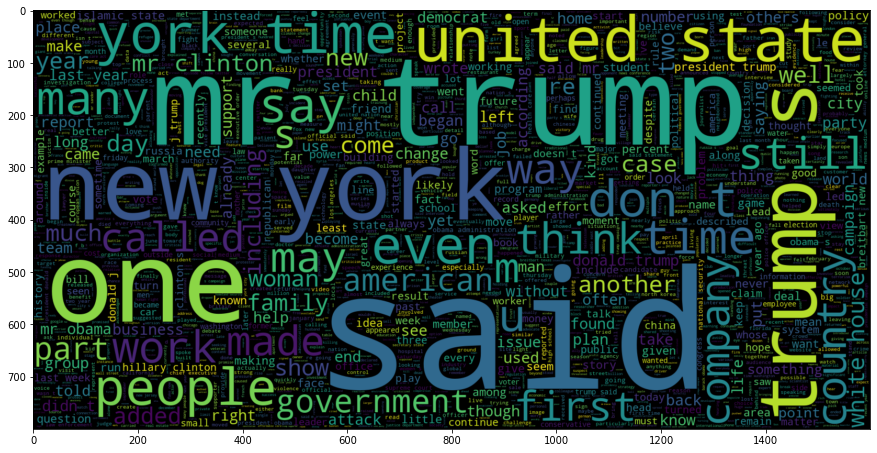

In [44]:
for s in [0,1]:
    if s == 0:
        print("Portstemmer")
    else:
        print("Lemmatization")
    preporcess(s,train)
    X_train, X_test, y_train, y_test = datasplit(train)
    for m in [0,1]: #loop for vect and modelling
        print("******************************************************")
        X_train_vect,X_test_vect = datavectorize(m,X_train,X_test)
        modelling(X_train_vect,X_test_vect,y_train,y_test)
        print("******************************************************")